## Today I'll be working on the cabin column.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path = "../../../Data/titanic/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

In [4]:
train = train.set_index("PassengerId")
test = test.set_index("PassengerId")

Apparently working on the entire dataset to fill nulls is better on the entire dataset to avoid overfitting. Will research this claim later.

In [6]:
all_df = pd.concat([train, test])

In [7]:
all_df["Deck"] = all_df["Cabin"].apply(lambda x: x[0] if pd.notnull(x) else "M")

In [8]:
all_df.drop("Cabin", axis=1, inplace=True)

### Visualization of Deck.

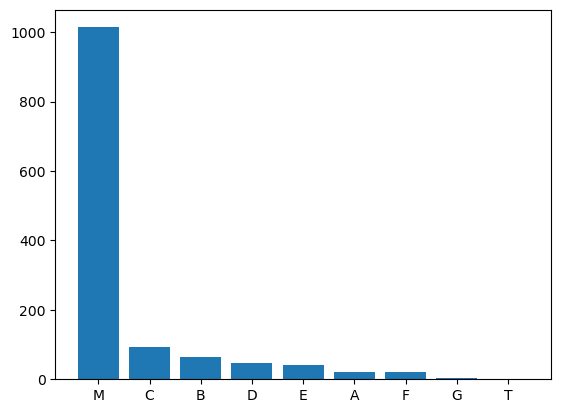

In [31]:
deck_count = all_df["Deck"].value_counts()
fig, ax = plt.subplots()
ax.bar(deck_count.index, deck_count.values)
plt.show()